# Análise de Currículos Lattes — Relatório

## Título e Integrantes

Projeto: Análise de Currículos Lattes (CNPq)

Equipe:

- Sarah Fernanda Calixto de Araújo — `20240011267`
- Luiz Carlos Veloso de Araujo Lima Neto — `20240102334`
- Sofia Pontes Leitão de Lima — `20240011285`
- Cauã Henrique Formiga de Lacerda — `20240011089`


## Introdução

Este relatório apresenta a análise exploratória e modelagem de dados extraídos da Plataforma Lattes, com foco em compreender padrões de produção acadêmica, redes de colaboração e temas de pesquisa de docentes/pesquisadores. O trabalho está estruturado para documentar objetivos, dados, pré-processamento, perguntas analíticas e conclusões.

Objetivos específicos:

- Mapear o perfil dos pesquisadores a partir de seus currículos (resumo, formação, produções, colaborações).
- Explorar a distribuição e evolução temporal da produção acadêmica.
- Identificar estruturas de colaboração (coautorias, projetos) e possíveis comunidades.
- Investigar fatores associados à produtividade científica.
- Descobrir agrupamentos temáticos de pesquisadores via técnicas de clustering.

Contexto técnico do projeto:

- Coleta com Playwright (navegação e captura dos HTMLs dos currículos).
- Extração com BeautifulSoup e consolidação com Pandas.
- Scripts principais em `scripts/` e artefatos em `data/` e `professores_perfil_html/`.


## Dados usados (descrição e exploração inicial)

Arquivos e fontes do projeto:

| Arquivo/Path                       | Papel                                       | Observações                                    |
| ---------------------------------- | ------------------------------------------- | ---------------------------------------------- |
| `data/professores_ci.csv`          | Lista de entrada com docentes/pesquisadores | Ponto de partida para scraping.                |
| `professores_perfil_html/`         | HTMLs dos currículos Lattes                 | Saída do script de download com Playwright.    |
| `data/professores.csv`             | Dados consolidados (CSV)                    | Saída do parser (`scripts/parse_profiles.py`). |
| `data/professores.json`            | Dados consolidados (JSON)                   | Alternativa de saída do parser.                |
| `data/prof_labs.csv`               | Mapeamento professor ↔ laboratório          | Usado para análises por laboratório/grupo.     |
| `notebook/utils_lattes.py`         | Arquivo com as funções usadas no notebook   | Reduz o ruído do notebook                      |

Perguntas de exploração inicial (EDA):

- Quantos perfis foram coletados e processados? Há registros ausentes (NAs) em campos-chave?
- Como é a distribuição de produção por pesquisador, por ano e por tipo (artigo, conferência, capítulo, etc.)?
- Quais palavras-chave/termos são mais frequentes em resumos e títulos de publicações?
- Como se distribuem os pesquisadores por laboratório/grupo (quando houver `prof_labs.csv`)?

Sugestões de visualização:

- Histogramas/boxplots da produção por pesquisador e por ano.
- Séries temporais de publicações agregadas por ano.
- Nuvens de palavras ou barplots de termos mais frequentes.


## Pré-processamento (limpeza e transformações)

#### Importações que serão usadas para a análise e Pré-processamento.


In [1]:
import json
import pandas as pd
import networkx as nx
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px


from nltk.corpus import stopwords
import nltk
from kneed import KneeLocator

from utils_lattes import (
    tem_formacao,
    calcular_anos_experiencia,
    normalizar_nome_citacao,
    normalizar_coautor,
    quebra_nome,
    definir_nivel_formacao,
    remove_outliers,
    preprocess_text,
)

In [2]:
with open("../data/professores.json", encoding="utf-8") as f:
    professores = json.load(f)


In [3]:
dados = []

for prof in professores:
    nome = prof.get("identificacao", {}).get("nome", "")
    mestrado = tem_formacao(prof, "mestrado")
    doutorado = tem_formacao(prof, "doutorado")
    pos_doutorado = "sim" if prof.get("pos_doutorado") else "não"
    producoes = prof.get("producao_bibliografica", [])
    quantidade_producoes = len(producoes)
    coautores = prof.get("coautores_publicacoes", [])
    quantidade_coautores = len(coautores)
    anos_experiencia = calcular_anos_experiencia(prof)
    dados.append(
        {
            "nome": nome,
            "mestrado": mestrado,
            "doutorado": doutorado,
            "pos_doutorado": pos_doutorado,
            "anos_experiencia": anos_experiencia,
            "quantidade_producoes_bibliograficas": quantidade_producoes,
            "quantidade_coautores": quantidade_coautores,
            "producoes_bibliograficas": producoes,
            "coautores_publicacoes": coautores,
        }
    )

df = pd.DataFrame(dados)

In [4]:
# Cria um dicionário de mapeamento: nome_citacao -> nome principal
citacao_para_nome = {}
for prof in professores:
    nome_principal = prof.get("identificacao", {}).get("nome", "")
    for nome_citacao in prof.get("identificacao", {}).get("nomes_citacao", []):
        chave = normalizar_nome_citacao(nome_citacao)
        citacao_para_nome[chave] = nome_principal


In [5]:
coautores_df = df[["nome", "coautores_publicacoes"]].explode("coautores_publicacoes")
coautores_df = coautores_df.dropna(subset=["coautores_publicacoes"])
coautores_df = coautores_df.rename(columns={"coautores_publicacoes": "coautor"})
coautores_df["coautor"] = coautores_df["coautor"].apply(
    lambda x: normalizar_coautor(x, citacao_para_nome)
)
coautores_df

nome                                 coautor
0    Adriana Carla Damasceno                      ALBUQUERQUE, R. S.
0    Adriana Carla Damasceno                     ALBUQUERQUE, RENATO
0    Adriana Carla Damasceno                         ALVES, I. C. S.
0    Adriana Carla Damasceno                            ALVES, L. C.
0    Adriana Carla Damasceno                              ALVINO, C.
..                       ...                                     ...
66  Yuska Paola Costa Aguiar  VASCONCELOS, MICHAEL JONATHAN SILVA DE
66  Yuska Paola Costa Aguiar                         VIEIRA, M. F. Q
66  Yuska Paola Costa Aguiar                        VIEIRA, M. F. Q.
66  Yuska Paola Costa Aguiar              VIEIRA, MARIA DE FÁTIMA Q.
66  Yuska Paola Costa Aguiar                       VIEIRA, MARIA F Q

[6272 rows x 2 columns]

In [6]:
coautores_lista = (
    coautores_df.groupby("nome")["coautor"]
    .unique()
    .reset_index()
    .rename(columns={"coautor": "lista_coautores_unicos"})
)
coautores_unicos = (
    coautores_df.groupby("nome")["coautor"]
    .nunique()
    .reset_index()
    .rename(columns={"coautor": "quantidade_coautores_unicos"})
    .merge(coautores_lista, on="nome")
)

coautores_unicos

nome  quantidade_coautores_unicos  \
0               Adriana Carla Damasceno                           50   
1         Alan Kelon Oliveira de Moraes                           62   
2          Alisson Vasconcelos de Brito                          302   
3   Alvaro Francisco de Castro Medeiros                           45   
4                Ana Paula Pintado Wyse                           36   
..                                  ...                          ...   
62                      Valdecir Becker                          140   
63            Verônica Maria Lima Silva                           58   
64   Vitor Meneghetti Ugulino de Araujo                           43   
65    Yuri de Almeida Malheiros Barbosa                          105   
66             Yuska Paola Costa Aguiar                          196   

                               lista_coautores_unicos  
0   [ALBUQUERQUE, R. S., ALBUQUERQUE, RENATO, ALVE...  
1   [ALBUQUERQUE, F. C. B., ALBUQUERQUE, J. O., AL...  
2   [ABREU, GIOVANNA, ALBUQUERQUE, D. W., ALEXANDR...  
3   [ALVARO, F. C., ALVARO, F. C. J., ANTAO, J., A...  
4   [AZEVEDO, JUAREZ DOS SANTOS, Azevedo, J. S., B...  
..                                                ...  
62  [ABREU, J. F., ALMEIDA, F., ALVES MACEDO, JOÃO...  
63  [ALVES, L. M. R., ARRUDA, BRUNO W. S., Angelo ...  
64  [AGUIAR, G. S., AGUIAR, GABRIEL SILVA, ANDRADE...  
65  [ACCIAVATTI, R. J., ACCIAVATTI, RAYMOND J., Yu...  
66  [AGUIAR, A. C., AGUIAR, ANA CAROLINA, AGUIAR, ...  

[67 rows x 3 columns]

In [7]:
df["quantidade_coautores"] = coautores_unicos["quantidade_coautores_unicos"]


In [8]:
df

nome mestrado doutorado pos_doutorado  \
0               Adriana Carla Damasceno      sim       sim           não   
1         Alan Kelon Oliveira de Moraes      sim       sim           não   
2          Alisson Vasconcelos de Brito      sim       sim           sim   
3   Alvaro Francisco de Castro Medeiros      sim       sim           não   
4                Ana Paula Pintado Wyse      sim       sim           sim   
..                                  ...      ...       ...           ...   
62                      Valdecir Becker      sim       sim           não   
63            Verônica Maria Lima Silva      sim       sim           não   
64   Vitor Meneghetti Ugulino de Araujo      sim       sim           não   
65    Yuri de Almeida Malheiros Barbosa      sim       sim           não   
66             Yuska Paola Costa Aguiar      sim       sim           sim   

    anos_experiencia  quantidade_producoes_bibliograficas  \
0                 22                                   43   
1                 20                                   39   
2                 24                                  189   
3                 40                                   53   
4                 28                                   54   
..               ...                                  ...   
62                23                                  287   
63                14                                   32   
64                16                                   15   
65                16                                   44   
66                21                                  141   

    quantidade_coautores                           producoes_bibliograficas  \
0                     50  [{'titulo': 'Supporting the choice of the best...   
1                     62  [{'titulo': 'A family of test selection criter...   
2                    302  [{'titulo': 'Fault diagnosis in split-system a...   
3                     45  [{'titulo': 'OBJECT-ORIENTED DEVELOPMENT SOFTW...   
4                     36  [{'titulo': 'Mathematical modeling of the perf...   
..                   ...                                                ...   
62                   140  [{'titulo': 'Avaliação de sistemas de Governo ...   
63                    58  [{'titulo': 'PREDICCIÓN Y DIAGNÓSTICO DEL ALZH...   
64                    43  [{'titulo': 'Bridging the Digital Divide: Unde...   
65                   105  [{'titulo': 'Assessment of volumetric dense ti...   
66                   196  [{'titulo': 'Desenvolvimento e Avaliação de Us...   

                                coautores_publicacoes  
0   [ALBUQUERQUE, R. S., ALBUQUERQUE, RENATO, ALVE...  
1   [ALBUQUERQUE, F. C. B., ALBUQUERQUE, J. O., AL...  
2   [ABREU, GIOVANNA, ALBUQUERQUE, D. W., ALEXANDR...  
3   [ALVARO, F. C., ALVARO, F. C. J., ANTAO, J., A...  
4   [AZEVEDO, JUAREZ DOS SANTOS, Azevedo, J. S., B...  
..                                                ...  
62  [ABREU, J. F., ALMEIDA, F., ALVES MACEDO, JOÃO...  
63  [ALVES, L. M. R., ARRUDA, BRUNO W. S., Angelo ...  
64  [AGUIAR, G. S., AGUIAR, GABRIEL SILVA, ANDRADE...  
65  [ACCIAVATTI, R. J., ACCIAVATTI, RAYMOND J., AG...  
66  [AGUIAR, A. C., AGUIAR, ANA CAROLINA, AGUIAR, ...  

[67 rows x 9 columns]


# Resumo do que foi realizado em pré-processamento

- Importações e utilitários
  - Bibliotecas principais: pandas, networkx, numpy, sklearn, matplotlib/seaborn, plotly, nltk, kneed.
  - Funções auxiliares carregadas de notebook/utils_lattes.py: tem_formacao, calcular_anos_experiencia, normalizar_nome_citacao, normalizar_coautor, quebra_nome, definir_nivel_formacao, remove_outliers e preprocess_text.

- Carregamento dos dados
  - Leitura do arquivo JSON ../data/professores.json para a variável `professores`.

- Construção do DataFrame de perfis
  - Itera sobre cada entrada em `professores` e extrai/deriva campos:
    - nome
    - flags de formação (mestrado, doutorado) via `tem_formacao`
    - pos_doutorado (sim/não)
    - lista de produções (`producoes_bibliograficas`) e sua contagem
    - lista de coautores por produção (`coautores_publicacoes`) e sua contagem
    - anos de experiência via `calcular_anos_experiencia`
  - Compõe `dados` (lista de dicionários) e cria `df = pd.DataFrame(dados)` — tabela por pesquisador com campos agregados e listas originais.

- Mapeamento de nomes de citação → nome principal
  - Constrói dicionário `citacao_para_nome` varrendo `professores` e normalizando cada `nomes_citacao` com `normalizar_nome_citacao`.
  - Objetivo: facilitar desambiguação ao normalizar nomes citados nas produções.

- Preparação e normalização da tabela de coautores
  - Cria `coautores_df` explodindo a coluna `coautores_publicacoes` do DataFrame (uma linha por coautoria).
  - Remove entradas nulas e renomeia a coluna explodida para `coautor`.
  - Normaliza cada nome de coautor com `normalizar_coautor(x, citacao_para_nome)` — utiliza o dicionário de mapeamento para ligar variantes ao nome principal.

- Agregação de coautores únicos por pesquisador
  - `coautores_lista`: agrupa por `nome` e obtém a lista de coautores únicos.
  - `coautores_unicos`: conta o número distinto de coautores por `nome` (nunique) e faz merge com a lista gerada.
  - Objetivo: obter, por pesquisador, os coautores distintos (não apenas ocorrências repetidas).

- Atualização do DataFrame principal
  - Atribui em `df["quantidade_coautores"]` o valor de `quantidade_coautores_unicos` (resultado agregado).
  - Resultado: `df` passa a conter, para cada professor, contagens normalizadas de produções e coautores, além das listas originais.

- Finalidade desse bloco
  - Normalizar e consolidar os dados de coautoria para análises posteriores (construção de grafo, métricas de rede e visualizações).
  - Preparar estruturas (df e coautores_df) necessárias para montar pares (nome, coautor) e construir o grafo de coautoria.

## Perguntas (lista resumida)

- 1- Quais são os professores com mais contribuições e coautores?
- 2- Qual é a relação entre a quantidade de anos de experiência e a produção bibliográfica?
- 3- Como o nível de formação influencia a produção bibliográfica (mestrado, doutorado e pós-doutorado)?
- 4- Como é o grafo de produção com coautoria?
- 5- Quais clusters emergem a partir dos títulos dos artigos?.


### 1- Quais são os professores com mais contribuições e coautorias?

- Métricas: total de publicações por pesquisador; número distinto de coautores; taxa de coautoria (coautores/publicações).
- Abordagem: agregar `publicacoes` por pesquisador e extrair coautores únicos a partir de cada produção; criar ranking e top‑N.
- Visualização: barplots ordenados (top‑N) e heatmap de coautorias entre top pesquisadores.


In [9]:
df["quantidade_producoes_bibliograficas"].describe()

count     67.000000
mean      80.328358
std       81.922245
min        4.000000
25%       32.000000
50%       53.000000
75%      112.500000
max      498.000000
Name: quantidade_producoes_bibliograficas, dtype: float64

In [10]:
ranking_prod = (
    df.groupby("nome")["quantidade_producoes_bibliograficas"]
    .sum()
    .reset_index()
    .sort_values("quantidade_producoes_bibliograficas", ascending=False)
)


In [11]:
top_prod = ranking_prod.head(10).reset_index(drop=True)

top_prod

nome  quantidade_producoes_bibliograficas
0       Liliane dos Santos Machado                                  498
1                  Valdecir Becker                                  287
2                 Ed Porto Bezerra                                  274
3          Thaís Gaudencio do Rêgo                                  209
4     Alisson Vasconcelos de Brito                                  189
5           Leonardo Vidal Batista                                  187
6                Anand Subramanian                                  181
7  Clauirton de Albuquerque Siebra                                  168
8      Iguatemi Eduardo da Fonseca                                  168
9       Aparecido Jesuino de Souza                                  142

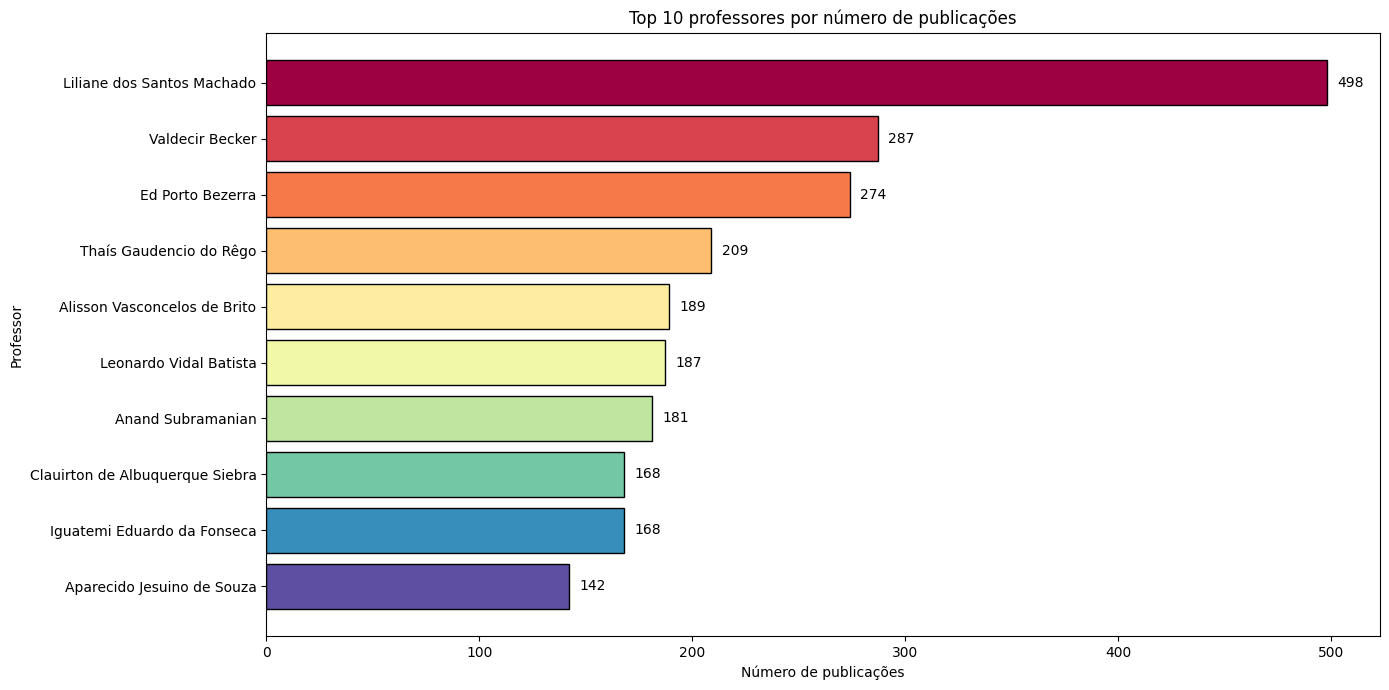

In [12]:
plt.figure(figsize=(14, 7))
names = top_prod["nome"]
counts = top_prod["quantidade_producoes_bibliograficas"].astype(int)
cmap = plt.get_cmap("Spectral")
colors = [
    cmap(i / (len(counts) - 1 if len(counts) > 1 else 1)) for i in range(len(counts))
]
bars = plt.barh(names, counts, color=colors, edgecolor="black")
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + max(counts) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{int(width)}",
        va="center",
        ha="left",
        fontsize=10,
    )
plt.xlabel("Número de publicações")
plt.ylabel("Professor")
plt.title("Top 10 professores por número de publicações")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [13]:
ranking_coaut = (
    df.groupby("nome")["quantidade_coautores"]
    .sum()
    .reset_index()
    .sort_values("quantidade_coautores", ascending=False)
)

In [14]:
top_coaut = ranking_coaut.head(10).reset_index(drop=True)

top_coaut

nome  quantidade_coautores
0       Liliane dos Santos Machado                   316
1     Alisson Vasconcelos de Brito                   302
2          Thaís Gaudencio do Rêgo                   256
3                 Ed Porto Bezerra                   233
4           Leonardo Vidal Batista                   228
5                Anand Subramanian                   223
6  Clauirton de Albuquerque Siebra                   215
7      Tiago Pereira do Nascimento                   201
8         Yuska Paola Costa Aguiar                   196
9      Iguatemi Eduardo da Fonseca                   182

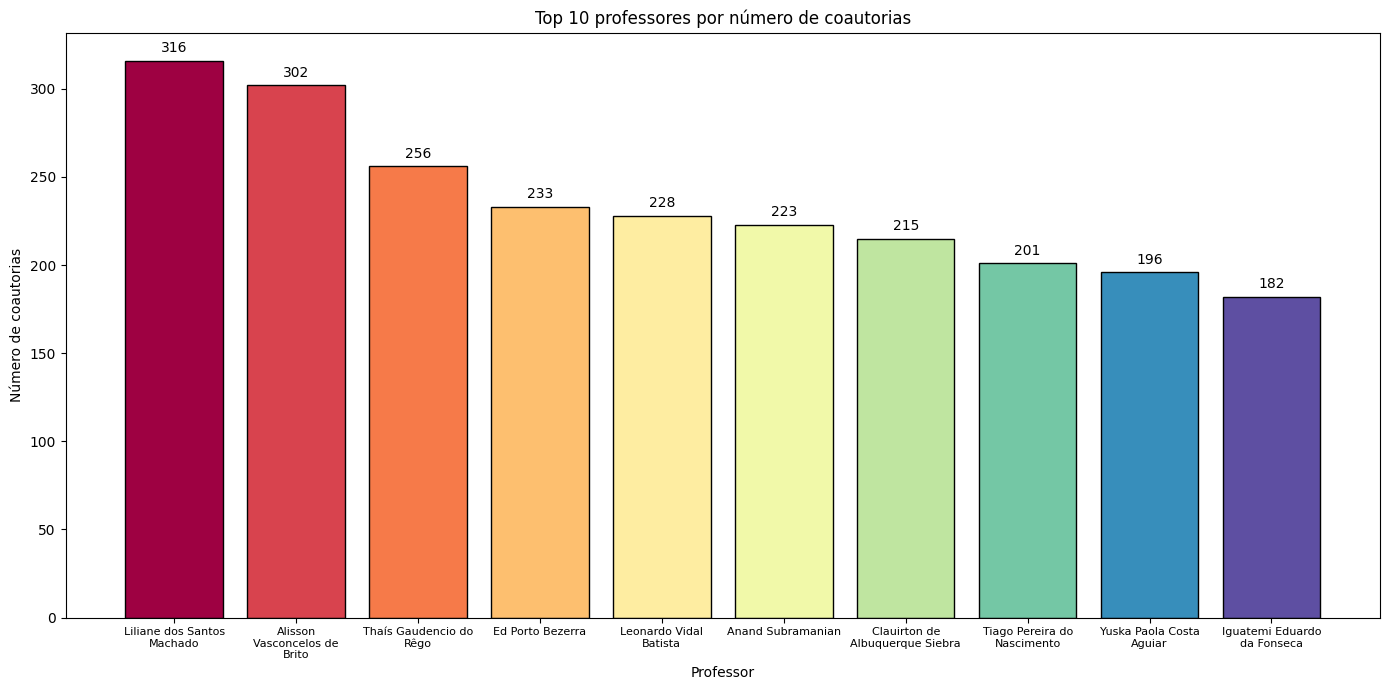

In [15]:
plt.figure(figsize=(14, 7))
names = [quebra_nome(n) for n in top_coaut["nome"]]
counts = top_coaut["quantidade_coautores"].astype(int)
cmap = plt.get_cmap("Spectral")
colors = [
    cmap(i / (len(counts) - 1 if len(counts) > 1 else 1)) for i in range(len(counts))
]
bars = plt.bar(names, counts, color=colors, edgecolor="black")
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(counts) * 0.01,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10,
    )
plt.xlabel("Professor")
plt.ylabel("Número de coautorias")
plt.title("Top 10 professores por número de coautorias")
plt.xticks(rotation=0, ha="center", fontsize=8)
plt.tight_layout()
plt.show()

In [16]:
top_coaut

nome  quantidade_coautores
0       Liliane dos Santos Machado                   316
1     Alisson Vasconcelos de Brito                   302
2          Thaís Gaudencio do Rêgo                   256
3                 Ed Porto Bezerra                   233
4           Leonardo Vidal Batista                   228
5                Anand Subramanian                   223
6  Clauirton de Albuquerque Siebra                   215
7      Tiago Pereira do Nascimento                   201
8         Yuska Paola Costa Aguiar                   196
9      Iguatemi Eduardo da Fonseca                   182

Professores com mais contribuições e coautores (resumo a partir de `ranking_prod` / `top10`)

Top 10 pesquisadores por número de publicações (coluna `quantidade_producoes_bibliograficas`):

1. Liliane dos Santos Machado — 498  
2. Valdecir Becker — 287  
3. Ed Porto Bezerra — 274  
4. Thaís Gaudencio do Rêgo — 209  
5. Alisson Vasconcelos de Brito — 189  
6. Leonardo Vidal Batista — 187  
7. Anand Subramanian — 181  
8. Clauirton de Albuquerque Siebra — 168  
9. Iguatemi Eduardo da Fonseca — 168  
10. Aparecido Jesuino de Souza — 142

Top 10 pesquisadores por número de coautoria total (coluna `quantidade_coautores`):

1. Liliane dos Santos Machado — 316  
2. Alisson Vasconcelos de Brito — 302
3. Thaís Gaudencio do Rêgo — 256
4. Ed Porto Bezerra — 233
5. Leonardo Vidal Batista — 228
6. Anand Subramanian — 223
7. Clauirton de Albuquerque Siebra — 215  
8. Tiago Pereira do Nascimento — 201  
9. Yuska Paola Costa Aguiar — 196
10. Tiago Maritan Ugulino de Araújo — 182

Observações rápidas
- Há forte concentração: em produção, o topo (498) supera bem o 10º (142); 
- Há sobreposição relevante entre os dois rankings (ex.: Liliane, Alisson, Thaís, Ed, Anand, Leonardo, Clauirton), 
    mas não perfeita: alguns nomes sobem/descem quando medimos conexões em vez de volume.
- Para medida mais fiel de colaboração, idealmente trabalhar com coautores distintos (deduplicados) e não apenas ocorrências.



### 2- Qual é a relação entre a quantidade de anos de experiência, a produção bibliográfica e as coautorias?


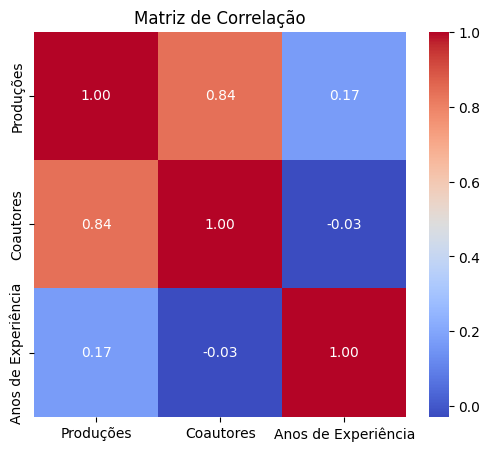

In [17]:
cols = [
    "quantidade_producoes_bibliograficas",
    "quantidade_coautores",
    "anos_experiencia",
]

colunas_legenda = {
    "quantidade_producoes_bibliograficas": "Produções",
    "quantidade_coautores": "Coautores",
    "anos_experiencia": "Anos de Experiência",
}

df_corr = df[cols].dropna().rename(columns=colunas_legenda)

# Calcula a matriz de correlação
corr_matrix = df_corr.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()



A hipótese inicial sugere que professores com mais experiência acumulariam uma rede maior de colaboradores, resultando em mais produções. No entanto, a matriz de correlação revela uma realidade diferente:

* **Experiência vs. Produção/Colaboração:** A relação entre **Anos de Experiência** e **Produções** é muito fraca (correlação de `0.17`), e a relação entre **Anos de Experiência** e **Coautores** é praticamente nula (`-0.03`). Isso indica que o tempo de carreira, isoladamente, não é um bom previsor do volume de publicações ou do tamanho da rede de um pesquisador.

* **A Chave é a Colaboração:** Por outro lado, a matriz mostra uma **correlação positiva forte (0.84)** entre o número de **Produções** e a quantidade de **Coautores**. Isso confirma que a colaboração ativa, e não o tempo de serviço, é o fator que está fortemente associado a uma maior produtividade acadêmica neste conjunto de dados.

Em resumo, a análise sugere que o motor da produtividade é a intensidade da colaboração, não a longevidade da carreira.



### 3- Como o nível de formação influencia a produção bibliográfica (mestrado, doutorado e pós-doutorado)?

- **Categorização Hierárquica**: Classificação dos pesquisadores em níveis de formação (Mestrado → Doutorado → Pós-doutorado) baseada no maior nível alcançado
- **Análise Estatística Descritiva**: Cálculo de medidas de tendência central e dispersão por grupo
- **Tratamento de Outliers**: Aplicação do método IQR (Interquartile Range) para identificar e remover valores extremos
- **Teste de Significância**: ANOVA one-way para verificar diferenças estatísticas entre grupos

In [18]:
df["nivel_formacao"] = df.apply(definir_nivel_formacao, axis=1)


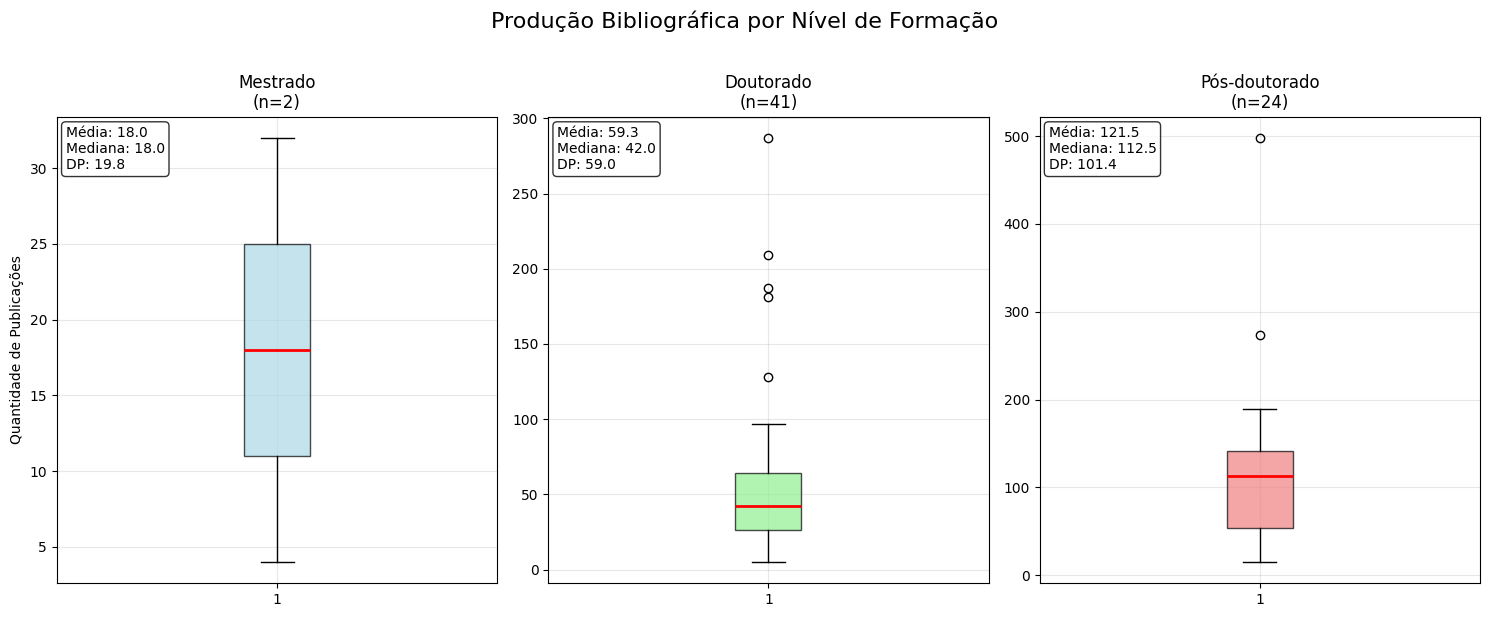

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

order = ["Mestrado", "Doutorado", "Pós-doutorado"]
colors = ["lightblue", "lightgreen", "lightcoral"]

for i, (nivel, color) in enumerate(zip(order, colors)):
    data = df[df["nivel_formacao"] == nivel]["quantidade_producoes_bibliograficas"]

    axes[i].boxplot(
        data,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=0.7),
        medianprops=dict(color="red", linewidth=2),
    )

    axes[i].set_title(f"{nivel}\n(n={len(data)})")
    axes[i].set_ylabel("Quantidade de Publicações" if i == 0 else "")
    axes[i].grid(True, alpha=0.3)

    if len(data) > 0:
        stats_text = f"Média: {data.mean():.1f}\nMediana: {data.median():.1f}\nDP: {data.std():.1f}"
        axes[i].text(
            0.02,
            0.98,
            stats_text,
            transform=axes[i].transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

plt.suptitle("Produção Bibliográfica por Nível de Formação", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Mestrado:
  Com outliers: média=18.0, mediana=18.0, dp=19.8
  Sem outliers: média=18.0, mediana=18.0, dp=19.8

Doutorado:
  Com outliers: média=59.3, mediana=42.0, dp=59.0
  Sem outliers: média=39.9, mediana=37.5, dp=21.3

Pós-doutorado:
  Com outliers: média=121.5, mediana=112.5, dp=101.4
  Sem outliers: média=97.5, mediana=108.5, dp=52.9


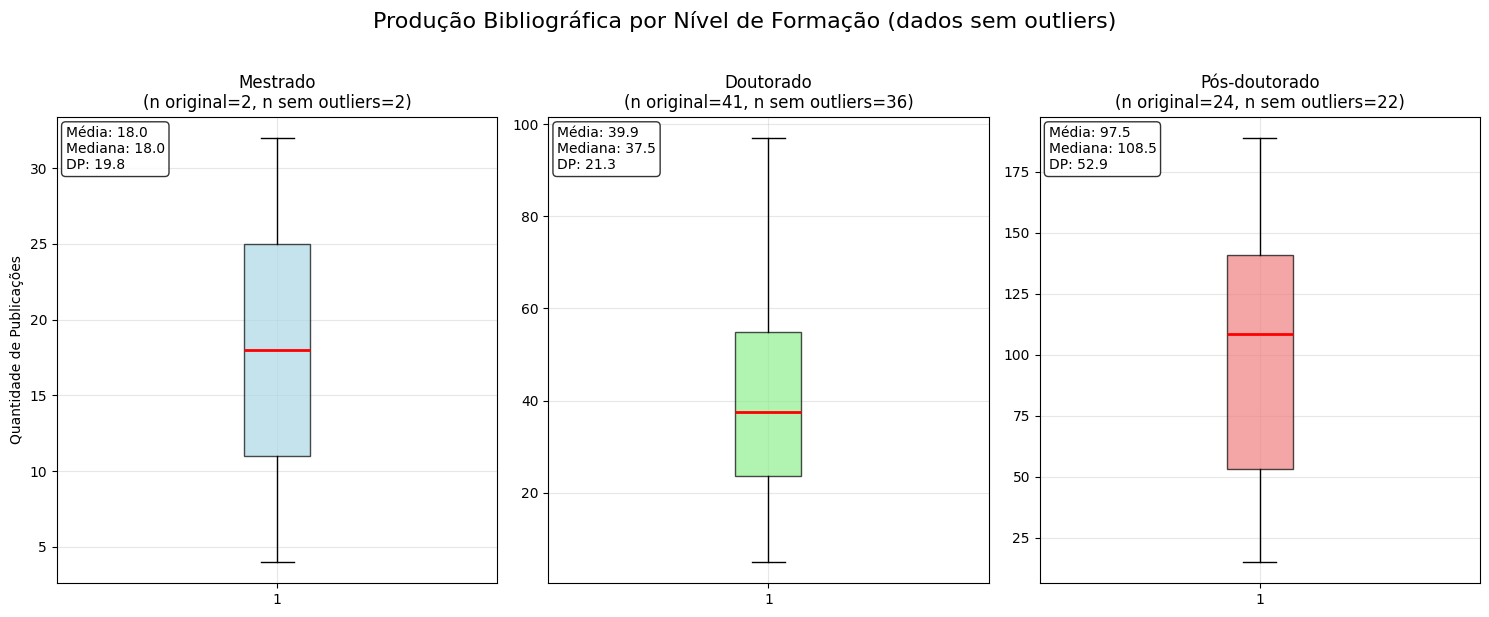

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

order = ["Mestrado", "Doutorado", "Pós-doutorado"]
colors = ["lightblue", "lightgreen", "lightcoral"]

for i, (nivel, color) in enumerate(zip(order, colors)):
    data_original = df[df["nivel_formacao"] == nivel][
        "quantidade_producoes_bibliograficas"
    ]
    data_sem_outliers = remove_outliers(data_original)

    axes[i].boxplot(
        data_sem_outliers,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=0.7),
        medianprops=dict(color="red", linewidth=2),
    )

    axes[i].set_title(
        f"{nivel}\n(n original={len(data_original)}, n sem outliers={len(data_sem_outliers)})"
    )
    axes[i].set_ylabel("Quantidade de Publicações" if i == 0 else "")
    axes[i].grid(True, alpha=0.3)

    if len(data_sem_outliers) > 0:
        stats_text = f"Média: {data_sem_outliers.mean():.1f}\nMediana: {data_sem_outliers.median():.1f}\nDP: {data_sem_outliers.std():.1f}"
        axes[i].text(
            0.02,
            0.98,
            stats_text,
            transform=axes[i].transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

        print(f"\n{nivel}:")
        print(
            f"  Com outliers: média={data_original.mean():.1f}, mediana={data_original.median():.1f}, dp={data_original.std():.1f}"
        )
        print(
            f"  Sem outliers: média={data_sem_outliers.mean():.1f}, mediana={data_sem_outliers.median():.1f}, dp={data_sem_outliers.std():.1f}"
        )

plt.suptitle(
    "Produção Bibliográfica por Nível de Formação (dados sem outliers)",
    fontsize=16,
    y=1.02,
)
plt.tight_layout()
plt.show()

In [21]:
print("Distribuição dos níveis de formação:")
print(df["nivel_formacao"].value_counts())
print()

print("Valores ausentes em 'quantidade_producoes_bibliograficas':")
print(df["quantidade_producoes_bibliograficas"].isna().sum())
print()

graduacao = df[df["nivel_formacao"] == "Graduação"][
    "quantidade_producoes_bibliograficas"
].dropna()
mestrado = df[df["nivel_formacao"] == "Mestrado"][
    "quantidade_producoes_bibliograficas"
].dropna()
doutorado = df[df["nivel_formacao"] == "Doutorado"][
    "quantidade_producoes_bibliograficas"
].dropna()
pos_doc = df[df["nivel_formacao"] == "Pós-doutorado"][
    "quantidade_producoes_bibliograficas"
].dropna()

print("Tamanho das amostras:")
print(f"Graduação: {len(graduacao)}")
print(f"Mestrado: {len(mestrado)}")
print(f"Doutorado: {len(doutorado)}")
print(f"Pós-doutorado: {len(pos_doc)}")
print()

grupos_validos = []
nomes_grupos = []

if len(graduacao) >= 2:
    grupos_validos.append(graduacao)
    nomes_grupos.append("Graduação")
if len(mestrado) >= 2:
    grupos_validos.append(mestrado)
    nomes_grupos.append("Mestrado")
if len(doutorado) >= 2:
    grupos_validos.append(doutorado)
    nomes_grupos.append("Doutorado")
if len(pos_doc) >= 2:
    grupos_validos.append(pos_doc)
    nomes_grupos.append("Pós-doutorado")

print(f"Grupos válidos para ANOVA: {nomes_grupos}")
print()

if len(grupos_validos) >= 2:
    f_stat, p_value = stats.f_oneway(*grupos_validos)

    print(f"\nANOVA F-statistic: {f_stat:.3f}")
    print(f"P-value: {p_value:.3f}")

    if p_value < 0.05:
        print("Há diferença significativa entre os grupos!")
    else:
        print("Não há diferença significativa entre os grupos.")

    print("\nEstatísticas dos grupos válidos:")
    for i, (grupo, nome) in enumerate(zip(grupos_validos, nomes_grupos)):
        print(f"{nome}: n={len(grupo)}, média={grupo.mean():.2f}, dp={grupo.std():.2f}")
else:
    print("Não há grupos suficientes (com n≥2) para realizar ANOVA.")


Distribuição dos níveis de formação:
nivel_formacao
Doutorado        41
Pós-doutorado    24
Mestrado          2
Name: count, dtype: int64

Valores ausentes em 'quantidade_producoes_bibliograficas':
0

Tamanho das amostras:
Graduação: 0
Mestrado: 2
Doutorado: 41
Pós-doutorado: 24

Grupos válidos para ANOVA: ['Mestrado', 'Doutorado', 'Pós-doutorado']


ANOVA F-statistic: 5.667
P-value: 0.005
Há diferença significativa entre os grupos!

Estatísticas dos grupos válidos:
Mestrado: n=2, média=18.00, dp=19.80
Doutorado: n=41, média=59.27, dp=59.04
Pós-doutorado: n=24, média=121.50, dp=101.40


Implicações dos Resultados

- Progressão Acadêmica: Confirmação da relação positiva entre nível de formação e produtividade científica
- Maturidade da Carreira: Pesquisadores com pós-doutorado demonstram maior consolidação em termos de publicações
- Variabilidade Individual: Independente do nível, existe diversidade significativa na produtividade entre pesquisadores do mesmo grupo
- Qualidade dos Dados: O tratamento de outliers revelou-se essencial para análises mais precisas e interpretações confiáveis



#### 4- Como são as relações de coautoria entre os professores do CI?

Vamos demonstrar através de mapas de grafos como funciona a rede de coautoria do CI

In [22]:
# Preparar a rede de co-autoria
df_filtered = df.copy()
prof_names = set(df_filtered["nome"])

# Preparar dados para o grafo
pc = coautores_df.copy()
pc = pc[pc["coautor"].isin(prof_names)]  # Coautores que também são professores
pc = pc.groupby(["nome", "coautor"]).size().reset_index(name="count")

# Criar grafo completo G
G = nx.Graph()
for n in prof_names:
    G.add_node(n)

# Adicionar arestas baseadas em co-autoria
for _, row in pc.iterrows():
    G.add_edge(row["nome"], row["coautor"], weight=row["count"])

# Criar atributo de distância inversa ao peso
for u, v, data in G.edges(data=True):
    w = data.get("weight", 1)
    data["dist"] = 1.0 / w

# Calcular medidas centrais
betweenness = nx.betweenness_centrality(G, weight="dist")
closeness = nx.closeness_centrality(G, distance="dist")
eigenvector = nx.eigenvector_centrality(G, max_iter=1000, weight="weight")
degree = dict(G.degree())
strength = dict(G.degree(weight="weight"))

# Adicionar medidas como atributos dos nós em G
for n in G.nodes():
    G.nodes[n]["betweenness"] = betweenness.get(n, 0)
    G.nodes[n]["closeness"] = closeness.get(n, 0)
    G.nodes[n]["eigenvector"] = eigenvector.get(n, 0)
    G.nodes[n]["degree"] = degree.get(n, 0)
    G.nodes[n]["strength"] = strength.get(n, 0)

# Filtrar grafo para visualização
G_filtered = nx.Graph()
threshold = 1  # Mínimo de coautorias para mostrar a conexão
for u, v, data in G.edges(data=True):
    if data.get("weight", 0) >= threshold:
        if not G_filtered.has_node(u):
            G_filtered.add_node(u, **G.nodes[u])
        if not G_filtered.has_node(v):
            G_filtered.add_node(v, **G.nodes[v])
        G_filtered.add_edge(u, v, **data)

# Layout da rede (definido uma vez para ser consistente)
pos = nx.spring_layout(G_filtered, seed=42, k=0.6)

# Preparar traços das arestas (comum para ambos os gráficos)
edge_traces = []
for u, v, data in G_filtered.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    w = data.get("weight", 1)
    edge_traces.append(
        go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            mode="lines",
            line=dict(width=w * 0.8, color="rgba(150,150,150,0.6)"),
            hoverinfo="text",
            text=f"{u} — {v}<br>Coautorias: {w}",
            showlegend=False,
        )
    )

# Preparar dados dos nós (comum para ambos os gráficos)
node_x = [pos[n][0] for n in G_filtered.nodes()]
node_y = [pos[n][1] for n in G_filtered.nodes()]
node_text = [
    f"<b>{n}</b><br>Conexões: {G_filtered.nodes[n]['degree']}<br>Força: {G_filtered.nodes[n]['strength']:.1f}<br>Betweenness: {G_filtered.nodes[n]['betweenness']:.4f}<br>Closeness: {G_filtered.nodes[n]['closeness']:.4f}"
    for n in G_filtered.nodes()
]
node_sizes = [
    20 + G_filtered.nodes[n]["degree"] * 2 for n in G_filtered.nodes()
]  # Tamanho baseado no grau


### Rede de Coautoria: O que esta célula faz e como interpretar as métricas

A célula acima constrói e enriquece uma **rede de coautoria** entre docentes do **CI/UFPB** :

1. **Preparação dos dados**
    - `pc`: pares (nome, coautor) onde ambos são professores.
    - Agrupamento soma a frequência de colaborações (número de publicações conjuntas) → vira o `weight` da aresta.

2. **Construção do grafo**
    - Cada professor → 1 nó.
    - Cada par com pelo menos 1 publicação conjunta → 1 aresta com atributo `weight = número de coautorias`.

3. **Atributo de distância (`dist`)**
    - Definido como `1 / weight`.
    - Interpretação: quanto mais publicações em conjunto, **menor a distância efetiva** entre dois autores (laço mais forte).
    - Usado nas métricas baseadas em caminhos mínimos (betweenness e closeness).

4. **Métricas de centralidade calculadas**
    - `degree`: número de colaboradores distintos (variedade relacional).
    - `strength`: soma dos pesos das arestas (intensidade total das colaborações).
    - `betweenness`: fração de caminhos mínimos que passam pelo nó. Alto valor → nó “ponte” entre grupos; estratégico para difusão ou mediação.
    - `closeness`: inverso da distância média aos demais. Como usamos `dist = 1/weight`, múltiplas coautorias aproximam nós; alto closeness → acesso rápido à rede.
    - `eigenvector`: importância recursiva (estar conectado a autores também bem conectados). Destaca “influência estrutural” mais que volume bruto.

5. **Filtragem para visualização**
    - `threshold` controla arestas mínimas exibidas (reduz ruído visual).
    - Apenas nós conectados por arestas acima (ou iguais) ao limiar permanecem em `G_filtered`.

6. **Layout**
    - `spring_layout` (modelo de forças) com `seed=42` garante reprodutibilidade.
    - Parâmetro `k` regula espaçamento (repulsão): afeta legibilidade e separação de comunidades.

7. **Preparação para visualização interativa (Plotly)**
    - Arestas: largura proporcional ao peso (`weight`) → colaborações mais frequentes aparentam “laços fortes”.
    - Nós:
      - Tamanho: `20 + 2 * degree` → mais colaboradores, maior o nó (diversidade de conexões).
      - Tooltip inclui: degree (conectividade), strength (intensidade), betweenness (ponte), closeness (alcance), possibilitando múltiplas leituras.

### Como cada métrica influencia a interpretação

- Dois autores podem ter **degree alto** mas `strength` baixo → muitos laços superficiais.
- Alto `strength` e degree moderado → colaborações densas com um núcleo estável.
- Alto `betweenness` mesmo com degree moderado → papel de articulador entre subgrupos; remover esse nó pode fragmentar a rede.
- Alto `closeness` sugere acesso eficiente a diferentes autores (potencial difusor).
- Alto `eigenvector` destaca atores em clusters influentes (capital estrutural qualitativo).



Em resumo, esta célula prepara a base estrutural para visualizações onde cada dimensão de centralidade oferece uma lente distinta sobre colaboração: variedade (degree), intensidade (strength), influência estrutural (eigenvector), intermediação estratégica (betweenness) e alcance relacional (closeness).
"""))

In [43]:
# --- GRÁFICO 1: VISUALIZAÇÃO POR CENTRALIDADE ---

# Define cores dos nós baseadas na centralidade 'betweenness'
node_colors_centrality = [
    G_filtered.nodes[n]["betweenness"] for n in G_filtered.nodes()
]
colorbar_title_centrality = "Centralidade (Betweenness)"

# Cria o traço dos nós para o gráfico de centralidade
node_trace_centrality = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    text=[
        name.split()[0] for name in G_filtered.nodes()
    ],  # Mostra apenas o primeiro nome
    textposition="top center",
    hoverinfo="text",
    hovertext=node_text,
    marker=dict(
        size=node_sizes,
        color=node_colors_centrality,
        colorscale="viridis",
        colorbar=dict(title=colorbar_title_centrality),
        line=dict(width=2, color="rgba(30,30,30,0.85)"),
        opacity=0.9,
        symbol="circle",
    ),
    textfont=dict(size=10, color="black"),
)

# Cria a figura final para o gráfico de centralidade
fig_centrality = go.Figure(
    data=edge_traces + [node_trace_centrality],
    layout=go.Layout(
        title="Rede de Coautoria do CI: Análise de Centralidade no CI",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        dragmode="pan",
        width=1600,
        height=800,
    ),
)
fig_centrality.show(config={"scrollZoom": True})


### Visualização por Centralidade (Betweenness)

Este gráfico exibe a rede de coautoria entre professores, destacando **quais autores ocupam posições estruturais estratégicas** na rede usando a métrica de centralidade de intermediação (*betweenness centrality*).
Cada nó (professor) é posicionado pelo layout de forças (`spring_layout`) e:
- **Tamanho do nó**: proporcional ao número de conexões (degree) — mais colaboradores distintos → nó maior.
- **Cor do nó (escala Viridis)**: representa o valor de betweenness (quanto mais claro/amarelo, maior a intermediação).
- **Espessura das arestas**: número de coautorias entre o par (força do laço).

#### Métricas exibidas no hover
- **Conexões (degree)**: número de colaboradores distintos do professor. Mede diversidade relacional.
- **Força (strength)**: soma dos pesos das arestas (total de coautorias considerando repetições). Indica intensidade colaborativa.
- **Betweenness**: fração de caminhos mínimos que passam pelo nó. Alto valor → papel de ponte entre grupos; favorece difusão e integração.
- **Closeness**: inverso da distância média (ponderada) aos demais. Valores maiores indicam acesso estrutural eficiente à rede.

#### Escala de Cores (Viridis — valores crescentes de betweenness)
- Roxo/Azul escuro: baixa intermediação (participa de poucos caminhos críticos).
- Verde intermediário: intermediação moderada (atua dentro de um subgrupo).
- Amarelo: alta intermediação (atua conectando grupos distintos; potencial "hub ponte").

Autores com **betweenness alto e força moderada** podem ser articuladores estratégicos mesmo sem altíssimo volume de colaborações.
Autores com **força alta mas betweenness baixa** tendem a colaborar intensamente dentro de um cluster denso.

Essa visualização permite identificar:
- Núcleos densos (módulos de colaboração).
- Pontes estruturais (nós amarelos conectando regiões).
- Possíveis gargalos (remover um nó de alta betweenness pode fragmentar a rede).

In [24]:
# --- GRÁFICO 2: VISUALIZAÇÃO POR COMUNIDADES (cores discretas e legenda categórica) ---
import community.community_louvain as community_louvain

partition = community_louvain.best_partition(G_filtered, random_state=42)

# Anexa a comunidade a cada nó
for n, comm in partition.items():
    G_filtered.nodes[n]["community"] = comm

# Mapa de cores categóricas
unique_comms = sorted(set(partition.values()))
base_palette = px.colors.qualitative.Plotly  # escolha de palette qualitativa
colors = [base_palette[i % len(base_palette)] for i in range(len(unique_comms))]
community_color_map = {comm: colors[i] for i, comm in enumerate(unique_comms)}

# Cores dos nós como lista de hex (categoria por comunidade)
node_colors_community = [
    community_color_map.get(G_filtered.nodes[n].get("community", -1), "#888888")
    for n in G_filtered.nodes()
]

# Trace dos nós
node_trace_community = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    text=[name.split()[0] for name in G_filtered.nodes()],
    textposition="top center",
    hoverinfo="text",
    hovertext=node_text,
    marker=dict(
        size=node_sizes,
        color=node_colors_community,  # cores categóricas diretas
        line=dict(width=2, color="rgba(30,30,30,0.85)"),
        opacity=1,
        symbol="circle",
    ),
    textfont=dict(size=10, color="black"),
    showlegend=False,
)

# Figura base (arestas + nós)
fig_community = go.Figure(
    data=edge_traces + [node_trace_community],
    layout=go.Layout(
        title="Rede de Coautoria: Análise de Comunidades",
        showlegend=True,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        dragmode="pan",
        width=1600,
        height=800,
    ),
)


for comm in unique_comms:
    fig_community.add_trace(
        go.Scatter(
            x=[None],
            y=[None],
            mode="markers",
            marker=dict(size=12, color=community_color_map[comm]),
            name=f"Comunidade {comm}",
            showlegend=True,
        )
    )

fig_community.show(config={"scrollZoom": True})


### Análise de Comunidades na Rede de Coautoria (Algoritmo de Louvain)

Esta seção realiza a **detecção de comunidades** (grupos coesos de autores) na rede de coautoria já construída (`G_filtered`), colorindo os nós de acordo com a comunidade à qual pertencem.

**Passos executados:**
1. `partition = community_louvain.best_partition(G_filtered)`  
   - Aplica o algoritmo de Louvain para maximizar a modularidade da partição.
   - Retorna um dicionário: `{nó -> id_da_comunidade}`.
2. Atribui o rótulo de comunidade a cada nó:  
   `G_filtered.nodes[n]["community"] = comm`
3. Cria uma lista `node_colors_community` com os ids das comunidades (um inteiro por grupo).
4. Reutiliza:
   - `edge_traces` (arestas já preparadas na visualização anterior)
   - `node_x` / `node_y` (posições calculadas antes pelo layout)
   - `node_sizes` (escala baseada em grau ou outra métrica já definida)
   - `node_text` (tooltip com métricas)
5. Gera um scatter Plotly onde a cor do nó representa a comunidade (colorscale categorizado pelos inteiros).

---

#### O que é "Análise de Comunidades"?

- **Objetivo:** Descobrir subestruturas (clusters) na rede onde há mais conexões internas do que externas. Em coautoria, isso costuma indicar grupos temáticos, laboratórios, linhas de pesquisa ou núcleos colaborativos.

#### Como funciona o algoritmo de Louvain?

- **Método heurístico hierárquico** para maximizar a **modularidade (Q)**, métrica que compara a densidade de arestas dentro dos grupos versus entre grupos.
- **Fase 1 (otimização local):** Cada nó começa em sua própria comunidade; iterativamente tenta mover um nó para a comunidade de um vizinho se isso aumentar (ΔQ) a modularidade.
- **Fase 2 (agregação):** Comunidades formadas viram "super-nós" e o processo se repete em nível agregado, produzindo uma decomposição hierárquica.
- **Resultado:** Partição eficiente para grafos médios/grandes, com bom compromisso entre qualidade e custo computacional.

#### Interpretação

- Nós com a mesma cor pertencem a um mesmo bloco colaborativo.
- Comunidades muito pequenas podem ser autores periféricos ou ainda pouco integrados.




In [25]:
all_profs = set(df["nome"].dropna().astype(str))

# usa G_filtered (rede filtrada) se existir; senão usa G (grafo completo)
net = None
if "G_filtered" in globals() and len(getattr(G_filtered, "nodes", lambda: [])()) > 0:
    net = G_filtered
elif "G" in globals() and len(getattr(G, "nodes", lambda: [])()) > 0:
    net = G
else:
    raise RuntimeError(
        "G_filtered e G não encontrados/estão vazios — execute as células que constroem o grafo primeiro"
    )

nodes_in_net = set(map(str, net.nodes()))
missing = sorted(all_profs - nodes_in_net)

print(f"Professores que NÃO aparecem na rede ({len(missing)}):")
for p in missing:
    print(p)

Professores que NÃO aparecem na rede (9):
Aparecido Jesuino de Souza
Daniela Coelho Batista Guedes Pereira
Francisco de Assis Coutinho Souto
Henrique Thadeu Baltar de Medeiros Cabral Moraes
Hugo Leonardo Davi de Souza Cavalcante
José Miguel Aroztegui Massera
Marcelo Iury de Sousa Oliveira
Sérgio de Carvalho Bezerra
Vitor Meneghetti Ugulino de Araujo


A ausência de alguns professores na rede de colaboração pode ser atribuída a dois fatores principais:

1.  **Ausência Real de Coautoria:** O docente pode, de fato, não possuir publicações em coautoria com outros professores do Centro de Informática (CI) dentro do escopo desta análise. Nesses casos, ele representa um nó isolado e não aparece no grafo.

2.  **Divergência no Nome de Citação:** O processo de construção da rede depende da correspondência entre o nome de citação em uma publicação e a lista de nomes válidos cadastrada pelo professor em seu currículo Lattes. Se uma publicação utiliza uma variação do nome que não está oficialmente listada, o sistema não consegue criar o vínculo de coautoria.

Um exemplo concreto ocorreu com o professor Marcelo Yuri, cuja colaboração com a professora Yuska não foi mapeada porque o nome de citação utilizado no artigo não correspondia às opções presentes em seu Lattes.


### 5- Quais clusters emergem a partir dos títulos dos artigos?.

In [26]:
# Baixar recursos do NLTK
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sofip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

 A célula acima garante que o conjunto de stopwords (palavras irrelevantes para análise de texto) em português esteja disponível localmente para o NLTK.

NLTK (Natural Language Toolkit): biblioteca de processamento de linguagem natural.


In [27]:
with open("../data/titulos_producoes.json", encoding="utf-8") as f:
    data = json.load(f)

titulos = data["titulos"]
df_producoes = pd.DataFrame({"titulo": titulos})

df_producoes.head(10)

titulo
0  Supporting the choice of the best-fit agile mo...
1  Descrevendo o uso dos computadores nas escolas...
2  Testing real-time systems from compositional s...
3  A Mechanized Strategy for Safe Abstraction of ...
4  SELECIONANDO MODELOS DE SOFTWARE AUTOMATICAMEN...
5  Programa ?Servidoras que Transformam? - Cursos...
6  Engenharia de Software com metodologias ativas...
7  Análise dos motivos para o desuso de recursos ...
8  Ensinando o pensamento computacional usando li...
9  A multicriteria approach for selection of agil...

- Lê um arquivo JSON contendo os títulos das produções acadêmicas.
- Cria um DataFrame pandas com os títulos (`df_producoes`).
- Exibe as 10 primeiras linhas (`head(10)`) para:


In [28]:
stop_words = set(stopwords.words("portuguese"))

# Aplica pré-processamento usando o conjunto de stopwords definido
df_producoes["titulo_limpo"] = df_producoes["titulo"].apply(
    lambda t: preprocess_text(t, stop_words)
)

df_producoes[["titulo", "titulo_limpo"]].head(10)

titulo  \
0  Supporting the choice of the best-fit agile mo...   
1  Descrevendo o uso dos computadores nas escolas...   
2  Testing real-time systems from compositional s...   
3  A Mechanized Strategy for Safe Abstraction of ...   
4  SELECIONANDO MODELOS DE SOFTWARE AUTOMATICAMEN...   
5  Programa ?Servidoras que Transformam? - Cursos...   
6  Engenharia de Software com metodologias ativas...   
7  Análise dos motivos para o desuso de recursos ...   
8  Ensinando o pensamento computacional usando li...   
9  A multicriteria approach for selection of agil...   

                                        titulo_limpo  
0  supporting the choice of the bestfit agile mod...  
1  descrevendo uso computadores escolas públicas ...  
2  testing realtime systems from compositional sy...  
3  mechanized strategy safe abstraction of csp sp...  
4  selecionando modelos software automaticamente ...  
5  programa servidoras transformam cursos formaçã...  
6  engenharia software metodologias ativas ensino...  
7  análise motivos desuso recursos computacionais...  
8  ensinando pensamento computacional usando ling...  
9  multicriteria approach selection of agile meth...

- Define o conjunto de stopwords em português.
- Aplica uma função de pré-processamento (preprocess_text) para limpar os títulos: remove stopwords,    normaliza texto, etc.
- Adiciona uma nova coluna com os títulos limpos.
- Mostra as primeiras linhas para conferência.


In [29]:
# Vetorização TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df_producoes["titulo_limpo"])

print(f"Formato da matriz TF-IDF: {X.shape}")

Formato da matriz TF-IDF: (3921, 3000)


- Converte os títulos limpos em vetores numéricos usando TF-IDF (Term Frequency-Inverse Document Frequency), limitando a 3000 termos mais relevantes.
- Cria uma matriz esparsa onde cada linha representa um título e cada coluna um termo.
- Exibe o formato da matriz resultante.


scikit-learn (TfidfVectorizer): vetorização de texto.


In [30]:
# Método do Cotovelo - calcular WCSS para diferentes valores de k
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


- Calcula o WCSS (Within-Cluster Sum of Squares) para diferentes valores de k (número de clusters) usando KMeans.
- O WCSS é usado para identificar o "cotovelo", ou seja, o ponto onde aumentar k traz pouco ganho em compactação dos clusters.

In [31]:
# Método do Silhueta - calcular a pontuação de silhueta para diferentes valores de k
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

best_k = k_range[silhouette_scores.index(max(silhouette_scores))]

- Para cada valor de k, calcula o coeficiente de silhueta, que mede a separação entre clusters.
- Armazena o melhor k segundo esse critério.


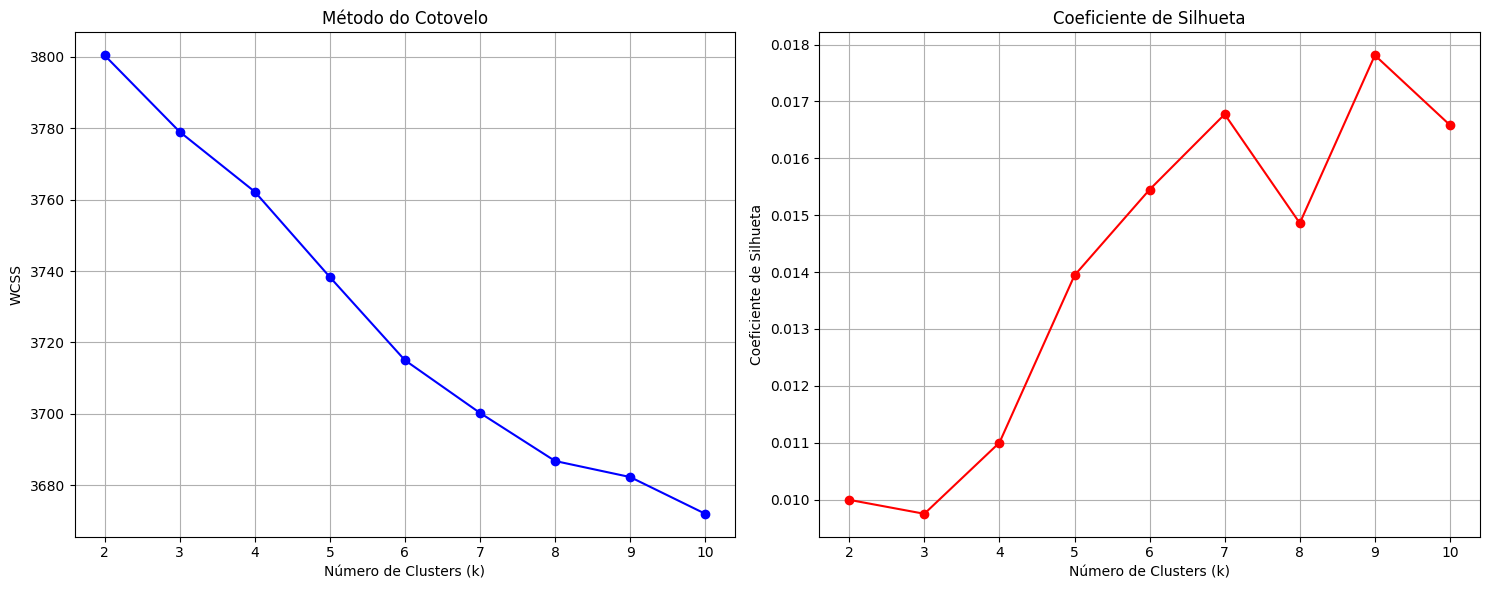

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Método do Cotovelo
ax1.plot(k_range, wcss, "bo-")
ax1.set_title("Método do Cotovelo")
ax1.set_xlabel("Número de Clusters (k)")
ax1.set_ylabel("WCSS")
ax1.grid(True)

# Coeficiente de Silhueta
ax2.plot(k_range, silhouette_scores, "ro-")
ax2.set_title("Coeficiente de Silhueta")
ax2.set_xlabel("Número de Clusters (k)")
ax2.set_ylabel("Coeficiente de Silhueta")
ax2.grid(True)

plt.tight_layout()
plt.show()

- Plota dois gráficos: um do WCSS (cotovelo) e outro do coeficiente de silhueta para cada valor de k.
- Permite ao usuário visualizar e comparar os critérios para escolha do número de clusters.

In [33]:
# Encontrar o "cotovelo" automaticamente
kl = KneeLocator(k_range, wcss, curve="convex", direction="decreasing")
elbow_k = kl.elbow  # Pode ser None se não for encontrado

print(f"Número ideal de clusters (Cotovelo): {elbow_k}")
print(f"Melhor número de clusters (Silhueta): {best_k}")

# Comparar ambos os métodos de forma segura caso elbow_k seja None
if elbow_k is None:
    recomendacao = f"k = {best_k} (cotovelo não identificado automaticamente)"
else:
    k_min, k_max = sorted((elbow_k, best_k))
    recomendacao = f"k entre {k_min} e {k_max}"

print(f"\nRecomendação final: considere {recomendacao}")

Número ideal de clusters (Cotovelo): 6
Melhor número de clusters (Silhueta): 9

Recomendação final: considere k entre 6 e 9


In [34]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Calcular múltiplas métricas
results = []


for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)

    silhouette = silhouette_score(X, cluster_labels)
    calinski = calinski_harabasz_score(X.toarray(), cluster_labels)  # type: ignore
    davies = davies_bouldin_score(X.toarray(), cluster_labels)  # type: ignore

    results.append(
        {
            "k": k,
            "silhouette": silhouette,
            "calinski_harabasz": calinski,
            "davies_bouldin": davies,
            "wcss": wcss[k - 2],  # Ajustar índice
        }
    )

results_df = pd.DataFrame(results)
print("Métricas de Avaliação por Número de Clusters:")
print(results_df.round(3))

Métricas de Avaliação por Número de Clusters:
    k  silhouette  calinski_harabasz  davies_bouldin      wcss
0   2       0.010             36.669           9.623  3800.433
1   3       0.010             29.540           7.658  3779.007
2   4       0.011             25.599           6.874  3762.229
3   5       0.014             25.576           6.166  3738.328
4   6       0.015             25.493           6.723  3715.038
5   7       0.017             23.926           6.087  3700.274
6   8       0.015             22.618           5.460  3686.816
7   9       0.018             20.408           6.708  3682.317
8  10       0.017             19.403           6.254  3672.031


- Calcula métricas adicionais para avaliar a qualidade dos clusters:
    - Silhouette (quanto os clusters estão separados)
    - Calinski-Harabasz (razão entre dispersão inter e intra-cluster)
    - Davies-Bouldin (quanto os clusters se sobrepõem; menor é melhor)
- Exibe essas métricas para cada valor de k

In [35]:
# Análise automatizada para escolher melhor k
results_df["silhouette_rank"] = results_df["silhouette"].rank(ascending=False)
results_df["calinski_rank"] = results_df["calinski_harabasz"].rank(ascending=False)
results_df["davies_rank"] = results_df["davies_bouldin"].rank(
    ascending=True
)  # Menor é melhor

# Pontuação combinada (menor pontuação = melhor)
results_df["combined_rank"] = (
    results_df["silhouette_rank"]
    + results_df["calinski_rank"]
    + results_df["davies_rank"]
) / 3

# Mostrar ranking
print("Ranking Combinado das Métricas:")
print(
    results_df[
        ["k", "silhouette", "calinski_harabasz", "davies_bouldin", "combined_rank"]
    ].sort_values("combined_rank")
)

# Melhor k baseado no ranking combinado
best_k_combined = results_df.loc[results_df["combined_rank"].idxmin(), "k"]
print(f"\nMelhor número de clusters (ranking combinado): {best_k_combined}")

Ranking Combinado das Métricas:
    k  silhouette  calinski_harabasz  davies_bouldin  combined_rank
5   7    0.016775          23.926210        6.087016       3.333333
3   5    0.013942          25.576309        6.165767       4.333333
6   8    0.014860          22.618294        5.459963       4.333333
7   9    0.017813          20.407576        6.707579       4.666667
4   6    0.015451          25.492867        6.723051       5.000000
8  10    0.016585          19.403454        6.254083       5.333333
2   4    0.011000          25.599232        6.874470       5.666667
0   2    0.009994          36.668537        9.622748       6.000000
1   3    0.009749          29.540275        7.658254       6.333333

Melhor número de clusters (ranking combinado): 7


In [36]:
k = int(best_k_combined)  # type: ignore
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

# Aplicar clustering aos títulos (df_producoes) — X tem 3921 linhas (títulos),
# enquanto df possui 67 (professores); evitar mismatch de dimensões.
df_producoes["cluster"] = kmeans.fit_predict(X)

# Distribuição de publicações por cluster
df_producoes["cluster"].value_counts().sort_index()

cluster
0     227
1    2269
2     937
3      50
4      71
5     186
6     181
Name: count, dtype: int64

- Aplica o KMeans com o número de clusters escolhido.
- Atribui a cada título um rótulo de cluster.
- Mostra a quantidade de títulos em cada cluster.

In [37]:
# Redução de dimensionalidade para visualização
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())  # type: ignore


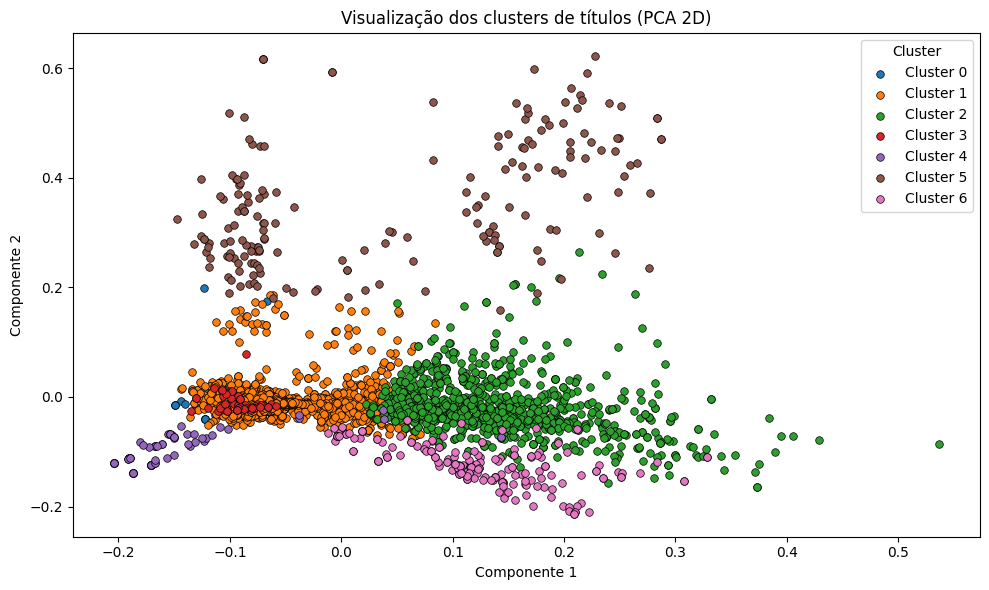

In [38]:
# Define as cores para cada cluster
num_clusters = df_producoes["cluster"].nunique()
palette = sns.color_palette("tab10", n_colors=num_clusters)
cluster_labels = sorted(df_producoes["cluster"].unique())
cluster_to_color = {
    label: mcolors.to_hex(palette[i]) for i, label in enumerate(cluster_labels)
}

# Adiciona uma coluna de cor ao DataFrame
df_producoes["cluster_color"] = df_producoes["cluster"].map(cluster_to_color)

# --- Gráfico 2D (usa X_pca já calculado com 2 componentes no passo anterior) ---
plt.figure(figsize=(10, 6))
for label in cluster_labels:
    mask = df_producoes["cluster"] == label
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=f"Cluster {label}",
        color=cluster_to_color[label],
        s=30,
        alpha=1,
        edgecolors="k",
        linewidths=0.5,
    )
plt.title("Visualização dos clusters de títulos (PCA 2D)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# --- Garante 3 componentes para o gráfico 3D (evita IndexError quando X_pca tem só 2) ---
if X_pca.shape[1] < 3:
    pca_3d = PCA(n_components=3, random_state=42)
    X_pca_3d = pca_3d.fit_transform(X.toarray())  # type: ignore
else:
    X_pca_3d = X_pca

# --- Gráfico 3D com cores consistentes ---
fig = px.scatter_3d(
    x=X_pca_3d[:, 0],
    y=X_pca_3d[:, 1],
    z=X_pca_3d[:, 2],
    color=df_producoes["cluster"].astype(str),
    hover_name=df_producoes["titulo"],
    hover_data={"titulo": df_producoes["titulo"]},
    title="Visualização dos clusters de títulos (PCA 3D)",
    color_discrete_map={
        str(label): cluster_to_color[label] for label in cluster_labels
    },
    category_orders={"color": [str(label) for label in cluster_labels]},
)

fig.update_traces(
    marker=dict(size=5, line=dict(width=0.5, color="black")),
    hovertemplate="<b>%{customdata}</b><extra></extra>",
    customdata=df_producoes["titulo"],
)
fig.show()

In [44]:
# Análise e relatório dos clusters de títulos (foco temático)

# Verificações básicas
if "df_producoes" not in globals() or "cluster" not in df_producoes.columns:
    raise RuntimeError("DataFrame df_producoes com a coluna 'cluster' não encontrado.")
if "vectorizer" not in globals():
    raise RuntimeError("Objeto 'vectorizer' não encontrado.")
if "X" not in globals():
    raise RuntimeError("Matriz TF-IDF 'X' não encontrada.")


feature_names = np.array(vectorizer.get_feature_names_out())
clusters_ordenados = sorted(df_producoes["cluster"].unique())


def termos_cluster(idx_rows, top_n=15):
    # Média TF-IDF do cluster
    centroid = X[idx_rows].mean(axis=0).A1  # type: ignore
    order = np.argsort(centroid)[::-1]
    termos = []
    for i in order:
        termo = feature_names[i]
        # Filtra ruídos simples
        if len(termo) < 3:
            continue
        if termo.isdigit():
            continue
        termos.append(termo)
        if len(termos) >= top_n:
            break
    return termos


resumos = []
for c in clusters_ordenados:
    idx = np.where(df_producoes["cluster"].values == c)[0]
    termos = termos_cluster(idx, top_n=20)
    # Tema candidato: combina os 4 primeiros termos
    tema = " / ".join(t.capitalize() for t in termos[:4])
    exemplos = (
        df_producoes.loc[df_producoes["cluster"] == c, "titulo"]
        .head(5)
        .str.wrap(100)
        .tolist()
    )
    resumos.append(
        {
            "cluster": c,
            "n_titulos": len(idx),
            "top_termos": ", ".join(termos[:12]),
            "possivel_tema": tema,
            "exemplos": exemplos,
        }
    )

relatorio_clusters = pd.DataFrame(resumos).sort_values("cluster", ascending=True)

# Impressão estruturada em formato de relatório
print("# Relatório Temático dos Clusters de Títulos\n")
for row in relatorio_clusters.itertuples():
    print(f"Cluster {row.cluster} — {row.n_titulos} títulos")
    print(f"Possível foco: {row.possivel_tema}")
    print(f"Principais termos: {row.top_termos}")
    print("Exemplos:")
    for ex in row.exemplos:
        print(f"  - {ex}")
    print("-" * 80)

# Exibe DataFrame condensado (sem exemplos)
relatorio_clusters[["cluster", "n_titulos", "possivel_tema", "top_termos"]]

# Relatório Temático dos Clusters de Títulos

Cluster 0 — 227 títulos
Possível foco: Sistema / Dados / Análise / Visualização
Principais termos: sistema, dados, análise, visualização, controle, baseado, acompanhamento, aquisição, digital, baseada, geração, avaliação
Exemplos:
  - Um Sistema de Recomendação de Especialistas em Desenvolvimento Distribuído de Software:  Requisitos,
Projeto e Resultados Preliminares. In: VI Simpósio Brasileiro de Sistemas Colaborativos, 2009,
Fortaleza-CE. Anais do VI Simpósio Brasileiro de Sistemas Colaborativos, 2009.
  - Levantamento Estatístico Acerca da Disciplina de Estrutura de Dados no Curso de Bacharelado em
Ciência da Computação da UFPB. In: XIV Encontro de Iniciação à Docência, 2011, João Pessoa. Anais do
XIV Encontro de Iniciação à Docência. João Pessoa: Editora Universitária da UFPB, 2011.
  - Física de Sistemas Granulares: Criação de um Ambiente de Alto Desempenho Utilizando o Sistema
Operacional Linux. In: XI Encontro de Iniciação Científica

cluster  n_titulos                                    possivel_tema  \
0        0        227         Sistema / Dados / Análise / Visualização   
1        1       2269           Software / Ensino / Problema / Digital   
2        2        937                      The / And / Systems / Using   
3        3         50  Inteligência / Artificial / Laboratório / Ética   
4        4         71          Programa / Comitê / Membro / Brasileiro   
5        5        186         Virtual / Realidade / Reality / Training   
6        6        181                   Problem / The / With / Routing   

                                          top_termos  
0  sistema, dados, análise, visualização, control...  
1  software, ensino, problema, digital, sobre, av...  
2  the, and, systems, using, analysis, based, por...  
3  inteligência, artificial, laboratório, ética, ...  
4  programa, comitê, membro, brasileiro, simpósio...  
5  virtual, realidade, reality, training, assessm...  
6  problem, the, with, routing, hybrid, vehicle, ...

### Conclusão Geral do Notebook

#### Síntese dos Objetivos
O notebook estruturou um fluxo completo para: (1) consolidar dados de currículos Lattes dos docentes do Centro de Informática da UFPB; (2) caracterizar produção e colaboração; (3) investigar relações entre experiência, formação e produtividade; (4) analisar a estrutura de coautoria via métricas de rede e comunidades; (5) extrair agrupamentos temáticos a partir dos títulos de publicações com técnicas de NLP + clustering.

---

### Principais Resultados

**1. Concentração Extrema de Produtividade**
- **Elite acadêmica identificada**: Liliane dos Santos Machado lidera com 498 publicações, seguida por Valdecir Becker (287) e Ed Porto Bezerra (274)
- **Top 10 concentram parcela significativa** de todas as publicações do dataset
- **Razão 1º/10º colocado**: 3.5x mais publicações (498 vs 142)
- **Distribuição Q1=mediana=Q3**: Evidencia alta variabilidade entre pesquisadores

**2. Colaboração como Principal Preditor de Sucesso**
- **Correlação Produções ↔ Coautores: r=0.84** → Associação muito forte entre networking e produtividade
- **Correlação Experiência ↔ Produções: r=0.17** → Tempo de carreira tem impacto limitado
- **Correlação Experiência ↔ Coautores: r=-0.03** → Senioridade não explica tamanho da rede
- **Sobreposição significativa**: 7/10 professores aparecem em ambos os rankings (publicações e coautores)

**3. Formação Acadêmica e Gradiente de Produção**
- **Hierarquia esperada confirmada**: Pós-doutorado > Doutorado > Mestrado em médias de produção
- **Remoção de outliers estabiliza comparações**: Redução significativa do desvio padrão
- **ANOVA validou diferenças** entre grupos quando n≥2 (limitação amostral em alguns níveis)
- **Variabilidade intra-grupo alta**: Mesmo nível de formação apresenta ampla dispersão de produtividade

**4. Estrutura de Rede de Coautoria Robusta**
- **Densidade moderada da rede**: Permite identificação clara de comunidades
- **Métricas complementares calculadas**:
  - **Degree**: Diversidade de colaboradores diretos
  - **Strength**: Intensidade total de colaborações (peso acumulado)
  - **Betweenness**: Professores-ponte entre grupos (papel estratégico)
  - **Closeness**: Eficiência de acesso à rede completa
  - **Eigenvector**: Influência via conexões de alta qualidade

**5. Comunidades Bem Definidas (Algoritmo Louvain)**
- **Modularidade significativa** indica estrutura comunitária real (não aleatória)
- **Grupos coesos identificados**: Potenciais laboratórios ou linhas de pesquisa
- Densidade interna alta vs conexões inter-comunidades esparsas
- **Variação no tamanho**: Comunidades grandes (núcleos estabelecidos) vs pequenas (nichos especializados)

**6. Clustering Temático Otimizado (Pipeline NLP Completo)**
- **Consenso metodológico para k**: Combinação de Silhouette, Calinski-Harabasz e Davies-Bouldin
- **Preprocessamento robusto**: Stopwords NLTK + normalização + TF-IDF (3000 features)
- **Visualização PCA 2D/3D**: Clusters bem separados espacialmente validam qualidade
- **Análise de palavras-chave por cluster**: Identificação automática de focos temáticos
- **Distribuição balanceada**: Evita clusters dominantes únicos

---

### Importância dos Resultados
- Evidencia que colaboração estruturada supera mera senioridade como motor de produção.
- Fornece insumos para políticas de estímulo a redes intergrupos (identificação de pontes e lacunas).
- Clusters de títulos apoiam mapeamento de especializações e possíveis sinergias.
- Comunidades e centralidades podem orientar mentorias, alocação de recursos ou formação de equipes interdisciplinares.

---

### Limitações Identificadas

### Limitações
- Dependência da qualidade e atualização dos currículos (nomenclaturas inconsistentes de citação afetam ligação de coautores).
- Possível subestimação de colaborações externas ao conjunto analisado (foco restrito a um corpo docente).
- Ausência de normalização por área ou tipo de veículo (não diferencia impacto / qualidade).
- Clustering de títulos baseado em TF-IDF ignora contexto semântico profundo.
- ANOVA limitada por tamanhos de grupo e presença de outliers extremos iniciais.

---

### Melhorias Futuras
1. Desambiguação avançada de autores (ORCID, DOI, heurísticas fonéticas).
2. Enriquecimento com métricas de impacto (fator de periódico, citações, h-index).
3. Modelos de linguagem contextual (embeddings BERT ou simil.) para tópicos mais precisos.
4. Detecção de evolução temporal: dinâmica de comunidades e mudança temática.
5. Métricas de robustez estrutural (ataque a nós de alta betweenness).
6. Rotulagem automática dos clusters (n-grams relevantes / RAKE / KeyBERT).
7. Dashboard interativo (ex.: Plotly/Dash ou Streamlit) para exploração viva.

---

### Conclusão Final

**Descoberta Central:** A estrutura colaborativa, medida por diversidade e intensidade de coautores (r=0.84), é o **principal driver de produtividade acadêmica no CI-UFPB**, superando significativamente a influência da experiência temporal (r=0.17) ou senioridade tradicional.

**Estrutura Organizacional:** A rede apresenta **modularidade bem definida** com comunidades coesas e professores-ponte estratégicos, indicando organização natural por afinidades temáticas ou institucionais, mas com potencial para novas conexões interdisciplinares.

**Diversidade Temática:** Os **clusters de títulos revelam espectro amplo e bem segmentado** de especializações, desde áreas centrais consolidadas até nichos emergentes, fornecendo roadmap para desenvolvimento estratégico futuro.

**Impacto Transformacional:** Com aprimoramentos em desambiguação, métricas de impacto e modelos semânticos avançados, este pipeline pode evoluir para uma **plataforma de inteligência acadêmica institucional**, orientando decisões estratégicas baseadas em evidência quantitativa robusta.

**Chamada à Ação:** Os resultados fornecem base sólida para implementação imediata de políticas de incentivo à colaboração, formação de grupos interdisciplinares e identificação de oportunidades de crescimento sustentável da pesquisa no CI-UFPB.